In [96]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding, Flatten
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
import keras

In [2]:
train = pd.read_csv("train.csv",usecols=[0,3,4])
test = pd.read_csv("test.csv",usecols=[0,3])

In [3]:
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB


(None, None)

In [5]:
train["text"].__contains__("@")

False

In [6]:
def prepro(t):
    t = t.lower()
    t = re.sub(r"[^a-zA-Z\s]","",t)
    t = re.sub("\s+"," ", t)
    return t 

In [7]:
train["text"] = train["text"].apply(prepro)

In [8]:
train.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,people receive wildfires evacuation orders in...,1
4,7,just got sent this photo from ruby alaska as s...,1


<Axes: >

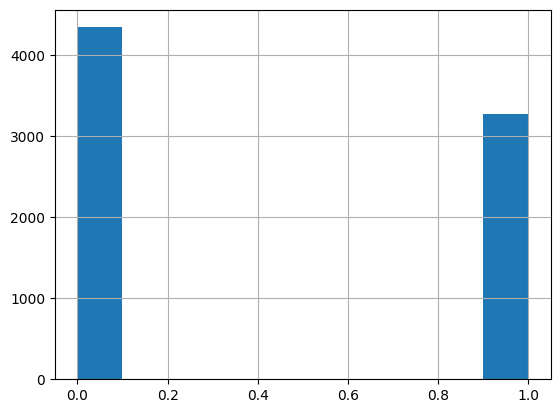

In [9]:
train["target"].hist()

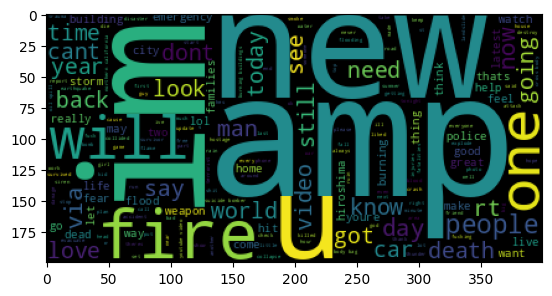

In [10]:
plt.imshow(WordCloud(background_color = 'black').generate(" ".join(train["text"])))

In [11]:
train["target"][:3000].sum(),train["target"][:3000].value_counts()

(1175,
 target
 0    1825
 1    1175
 Name: count, dtype: int64)

In [12]:
Xtra, Xtes, Ytra, Ytes = train_test_split(train["text"], train["target"],test_size=0.15)

In [13]:
countpipeline = Pipeline(
    [
        ("count",CountVectorizer()),
        ("model",LogisticRegression(random_state=44,C=0.3,max_iter=500,solver="sag"))
    ]
)

In [14]:
countpipeline.fit(Xtra,Ytra)

Pipeline(steps=[('count', CountVectorizer()),
                ('model',
                 LogisticRegression(C=0.3, max_iter=500, random_state=44,
                                    solver='sag'))])

In [15]:
countpipeline.score(Xtra,Ytra),countpipeline.score(Xtes,Ytes)

(0.9270591871426364, 0.8204903677758318)

<Axes: >

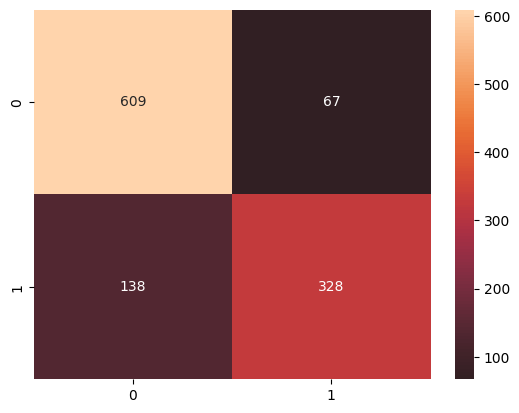

In [16]:
sns.heatmap(confusion_matrix(Ytes,countpipeline.predict(Xtes)),center=True,annot=True,fmt="g")

In [17]:
tfidpipeline = Pipeline(
    [
        ("tfid",TfidfVectorizer()),
        ("model",LogisticRegression(random_state=44,C=0.3,max_iter=500,solver="sag"))
    ]
)

In [18]:
tfidpipeline.fit(Xtra,Ytra)

Pipeline(steps=[('tfid', TfidfVectorizer()),
                ('model',
                 LogisticRegression(C=0.3, max_iter=500, random_state=44,
                                    solver='sag'))])

In [19]:
tfidpipeline.score(Xtra,Ytra),tfidpipeline.score(Xtes,Ytes)

(0.8378921341369185, 0.7985989492119089)

<Axes: >

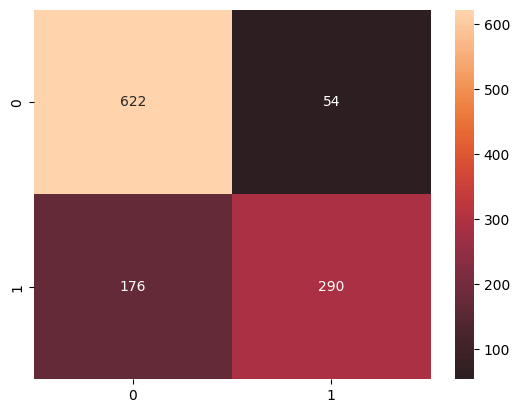

In [20]:
sns.heatmap(confusion_matrix(Ytes,tfidpipeline.predict(Xtes)),center=True,annot=True,fmt="g")

In [21]:
glove_embeding = {}
with open("/home/bananaboi/coding/python/ml0/nlp n chatbots exp/glove.6B.100d.txt") as glove_file:
    for line in glove_file:
        parts = line.strip().split()
        embedding = np.array([float(x) for x in parts[1:]])
        glove_embeding[parts[0]] = embedding

In [22]:
glove_embeding["banana"]

array([-0.34028  ,  0.46436  , -0.083324 ,  0.20186  , -0.17831  ,
       -0.4663   ,  0.61793  ,  0.30129  ,  0.5728   , -0.34783  ,
       -0.9216   ,  0.30484  ,  0.30382  ,  0.58035  ,  0.12112  ,
        0.77288  ,  1.1547   , -0.576    ,  0.51471  ,  0.21552  ,
        0.21106  ,  0.67875  ,  1.1962   ,  0.11142  ,  0.50809  ,
        1.1873   ,  0.035288 , -0.88952  ,  0.042803 , -0.36714  ,
        0.37993  ,  0.61945  ,  1.0194   , -0.95084  , -0.0072258,
        0.69454  ,  0.38692  , -0.18544  ,  0.2885   , -0.81279  ,
       -0.46473  , -0.82623  ,  0.42778  , -0.14064  ,  0.30173  ,
        0.074418 , -0.40044  ,  0.33969  , -0.62917  , -0.054449 ,
       -0.78469  ,  0.2354   , -0.78359  ,  0.74708  , -0.31074  ,
       -0.07038  , -0.34623  ,  0.33849  ,  0.89621  ,  0.30288  ,
        0.012978 ,  0.020869 , -0.14436  , -0.40914  ,  0.16651  ,
       -0.88124  , -0.078419 ,  0.048156 ,  0.27032  , -0.81761  ,
        0.027778 ,  0.62487  ,  0.1549   , -0.15838  ,  0.0886

In [23]:
Xtra

4304    the prophet peace be upon him said save yourse...
844     sean end career sg blizzard vs knockout httptc...
7152    this la startup is so hot that their flowers c...
5362    love it when jesse suffers a panic attack http...
3530    rt patrickjbutler excellent damiengayle eyewit...
                              ...                        
6110    wccorosen did lloyds of london insure your bet...
5054          some people are really natural disaster too
3738    morganite gemstone white fire opal sterling si...
1262    hinton city officials confirm multiple buildin...
1955    video new de jhaustin thomas on being a cyclon...
Name: text, Length: 6471, dtype: object

In [24]:
t = Tokenizer()
t.fit_on_texts(train["text"])

In [25]:
word_count = len(t.word_index)+1

In [26]:
word_count

21492

In [27]:
encdText = t.texts_to_sequences(Xtra)

In [28]:
encdTextT = t.texts_to_sequences(Xtes)

In [29]:
padded = pad_sequences(encdText,maxlen=31,padding="post")

In [30]:
paddedT = pad_sequences(encdTextT,maxlen=31,padding="post")

In [31]:
embedding_matrix = np.zeros((word_count, 100))

In [32]:
for word,i in t.word_index.items():
    embedding_vector = glove_embeding.get(word)
    if embedding_vector is not None:embedding_matrix[i] = embedding_vector

In [33]:
t.word_index.items()

dict_items([('the', 1), ('a', 2), ('in', 3), ('to', 4), ('of', 5), ('and', 6), ('i', 7), ('is', 8), ('for', 9), ('on', 10), ('you', 11), ('my', 12), ('with', 13), ('it', 14), ('that', 15), ('at', 16), ('by', 17), ('this', 18), ('from', 19), ('be', 20), ('are', 21), ('have', 22), ('was', 23), ('like', 24), ('as', 25), ('me', 26), ('up', 27), ('just', 28), ('so', 29), ('but', 30), ('im', 31), ('amp', 32), ('not', 33), ('your', 34), ('its', 35), ('out', 36), ('after', 37), ('all', 38), ('will', 39), ('when', 40), ('no', 41), ('fire', 42), ('an', 43), ('has', 44), ('if', 45), ('we', 46), ('get', 47), ('new', 48), ('now', 49), ('via', 50), ('more', 51), ('about', 52), ('dont', 53), ('or', 54), ('what', 55), ('news', 56), ('people', 57), ('he', 58), ('one', 59), ('they', 60), ('how', 61), ('been', 62), ('over', 63), ('who', 64), ('into', 65), ('us', 66), ('do', 67), ('were', 68), ('video', 69), ('can', 70), ('emergency', 71), ('disaster', 72), ('there', 73), ('police', 74), ('than', 75), ('h

In [122]:
modelGlove = Sequential()

In [123]:
modelGlove.add(Embedding(21492, 100, weights=[embedding_matrix], input_length=31, trainable=False))
modelGlove.add(Flatten())
modelGlove.add(Dense(768, activation="tanh"))
modelGlove.add(Dense(1))

In [124]:
modelGlove.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 31, 100)           2149200   
                                                                 
 flatten_12 (Flatten)        (None, 3100)              0         
                                                                 
 dense_27 (Dense)            (None, 768)               2381568   
                                                                 
 dense_28 (Dense)            (None, 1)                 769       
                                                                 
Total params: 4531537 (17.29 MB)
Trainable params: 2382337 (9.09 MB)
Non-trainable params: 2149200 (8.20 MB)
_________________________________________________________________


In [125]:
modelGlove.compile(optimizer="adam",loss="binary_crossentropy",metrics=[keras.metrics.BinaryAccuracy()])

In [126]:
history = modelGlove.fit(padded,Ytra,epochs=100,verbose=1)

Epoch 1/100
203/203 [==============================] - 5s 24ms/step - loss: 5.2430 - binary_accuracy: 0.6438
Epoch 2/100
203/203 [==============================] - 5s 25ms/step - loss: 4.9706 - binary_accuracy: 0.6671
Epoch 3/100
203/203 [==============================] - 5s 24ms/step - loss: 4.9138 - binary_accuracy: 0.6707
Epoch 4/100
203/203 [==============================] - 5s 24ms/step - loss: 5.6363 - binary_accuracy: 0.6236
Epoch 5/100
203/203 [==============================] - 5s 24ms/step - loss: 5.4001 - binary_accuracy: 0.6418
Epoch 6/100
203/203 [==============================] - 5s 24ms/step - loss: 5.0583 - binary_accuracy: 0.6645
Epoch 7/100
203/203 [==============================] - 5s 24ms/step - loss: 4.6329 - binary_accuracy: 0.6931
Epoch 8/100
203/203 [==============================] - 5s 24ms/step - loss: 3.9972 - binary_accuracy: 0.7331
Epoch 9/100
203/203 [==============================] - 5s 23ms/step - loss: 3.7513 - binary_accuracy: 0.7503
Epoch 10/100
203/20

In [127]:
modelGlove.evaluate(paddedT,Ytes)

36/36 [==============================] - 0s 3ms/step - loss: 3.7327 - binary_accuracy: 0.7487


[3.7327404022216797, 0.7486864924430847]

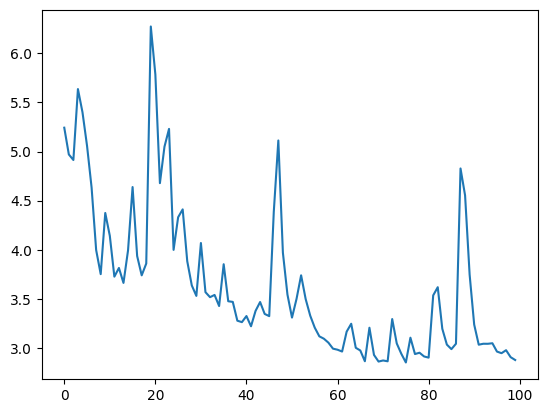

In [128]:
plt.plot(history.history["loss"])

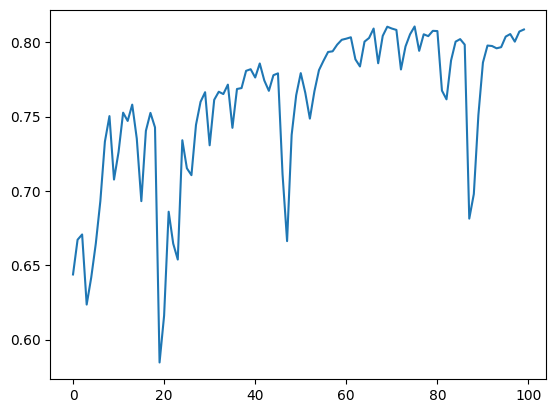

In [129]:
plt.plot(history.history["binary_accuracy"])


In [130]:
modelGlove.save("model0")

INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets
